In [9]:
# This code is part of a Qiskit project.
#
# (C) Copyright IBM 2017, 2024.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

"""The log-normal probability distribution circuit."""

from typing import Tuple, List, Union, Optional
import numpy as np

from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import Initialize, Isometry


class LogNormalDistribution(QuantumCircuit):
    r"""A circuit to encode a discretized log-normal distribution in qubit amplitudes.

    A random variable :math:`X` is log-normal distributed if

    .. math::

        \log(X) \sim \mathcal{N}(\mu, \sigma^2)

    for a normal distribution :math:`\mathcal{N}(\mu, \sigma^2)`.
    The probability density function of the log-normal distribution is defined as

    .. math::

        \mathbb{P}(X = x) = \frac{1}{x\sqrt{2\pi\sigma^2}} e^{-\frac{(\log(x) - \mu)^2}{\sigma^2}}

    .. note::

        The parameter ``sigma`` in this class equals the **variance**, :math:`\sigma^2` and not the
        standard deviation. This is for consistency with multivariate distributions, where the
        uppercase sigma, :math:`\Sigma`, is associated with the covariance.

    This circuit considers the discretized version of :math:`X` on ``2 ** num_qubits`` equidistant
    points, :math:`x_i`, truncated to ``bounds``.  The action of this circuit can be written as

    .. math::

        \mathcal{P}_X |0\rangle^n = \sum_{i=0}^{2^n - 1} \sqrt{\mathbb{P}(x_i)} |i\rangle

    where :math:`n` is `num_qubits`.

    .. note::

        The circuit loads the **square root** of the probabilities into the qubit amplitudes such
        that the sampling probability, which is the square of the amplitude, equals the
        probability of the distribution.

    This circuit is for example used in amplitude estimation applications, such as finance [1, 2],
    where customer demand or the return of a portfolio could be modeled using a log-normal
    distribution.

    Examples:
        This class can be used for both univariate and multivariate distributions.

        >>> from qiskit_finance.circuit.library.probability_distributions import LogNormalDistribution
        >>> mu = [1, 0.9, 0.2]
        >>> sigma = [[1, -0.2, 0.2], [-0.2, 1, 0.4], [0.2, 0.4, 1]]
        >>> circuit = LogNormalDistribution([2, 2, 2], mu, sigma)
        >>> circuit.num_qubits
        6

    References:
        [1]: Gacon, J., Zoufal, C., & Woerner, S. (2020).
             Quantum-Enhanced Simulation-Based Optimization.
             `arXiv:2005.10780 <http://arxiv.org/abs/2005.10780>`_

        [2]: Woerner, S., & Egger, D. J. (2018).
             Quantum Risk Analysis.
             `arXiv:1806.06893 <http://arxiv.org/abs/1806.06893>`_

    """

    def __init__(
        self,
        num_qubits: Union[int, List[int]],
        mu: Optional[Union[float, List[float]]] = None,
        sigma: Optional[Union[float, List[float]]] = None,
        bounds: Optional[Union[Tuple[float, float], List[Tuple[float, float]]]] = None,
        upto_diag: bool = False,
        name: str = "P(X)",
    ) -> None:
        r"""
        Args:
            num_qubits: The number of qubits used to discretize the random variable. For a 1d
                random variable, ``num_qubits`` is an integer, for multiple dimensions a list
                of integers indicating the number of qubits to use in each dimension.
            mu: The parameter :math:`\mu` of the distribution.
                Can be either a float for a 1d random variable or a list of floats for a higher
                dimensional random variable.
            sigma: The parameter :math:`\sigma^2` or :math:`\Sigma`, which is the variance or
                covariance matrix.
            bounds: The truncation bounds of the distribution as tuples. For multiple dimensions,
                ``bounds`` is a list of tuples ``[(low0, high0), (low1, high1), ...]``.
                If ``None``, the bounds are set to ``(0, 1)`` for each dimension.
            upto_diag: If True, load the square root of the probabilities up to multiplication
                with a diagonal for a more efficient circuit.
            name: The name of the circuit.
        """

        # set default arguments
        dim = 1 if isinstance(num_qubits, int) else len(num_qubits)
        if mu is None:
            mu = 0 if dim == 1 else [0] * dim

        if sigma is None:
            sigma = 1 if dim == 1 else np.eye(dim)  # type: ignore[assignment]

        if bounds is None:
            bounds = (0, 1) if dim == 1 else [(0, 1)] * dim

        if isinstance(num_qubits, int):  # univariate case
            inner = QuantumCircuit(num_qubits, name=name)

            x = np.linspace(bounds[0], bounds[1], num=2**num_qubits)
        else:  # multivariate case
            inner = QuantumCircuit(sum(num_qubits), name=name)

            # compute the evaluation points using meshgrid of numpy
            # indexing 'ij' yields the "column-based" indexing
            meshgrid = np.meshgrid(
                *[
                    np.linspace(bound[0], bound[1], num=2 ** num_qubits[i])  # type: ignore
                    for i, bound in enumerate(bounds)
                ],
                indexing="ij",
            )
            # flatten into a list of points
            x = list(zip(*[grid.flatten() for grid in meshgrid]))  # type: ignore

        # compute the normalized, truncated probabilities
        probabilities = []
        from scipy.stats import multivariate_normal

        for x_i in x:
            # map probabilities from normal to log-normal reference:
            # https://stats.stackexchange.com/questions/214997/multivariate-log-normal-probabiltiy-density-function-pdf
            if np.min(x_i) > 0:
                det = 1 / np.prod(x_i)
                probability = multivariate_normal.pdf(np.log(x_i), mu, sigma) * det
            else:
                probability = 0
            probabilities += [probability]
        normalized_probabilities = probabilities / np.sum(probabilities)

        # store as properties
        self._values = x
        self._probabilities = normalized_probabilities
        self._bounds = bounds

        super().__init__(*inner.qregs, name=name)

        # use default the isometry (or initialize w/o resets) algorithm to construct the circuit
        if upto_diag:
            inner.append(Isometry(np.sqrt(normalized_probabilities), 0, 0), inner.qubits)
            self.append(inner.to_instruction(), inner.qubits)  # Isometry is not a Gate
        else:
            initialize = Initialize(np.sqrt(normalized_probabilities))
            circuit = initialize.gates_to_uncompute().inverse()
            inner.compose(circuit, inplace=True)
            self.append(inner.to_gate(), inner.qubits)

    @property
    def values(self) -> np.ndarray:
        """Return the discretized points of the random variable."""
        return self._values

    @property
    def probabilities(self) -> np.ndarray:
        """Return the sampling probabilities for the values."""
        return self._probabilities

    @property
    def bounds(self) -> Union[Tuple[float, float], List[Tuple[float, float]]]:
        """Return the bounds of the probability distribution."""
        return self._bounds

In [10]:
num_price_qubits = 3
strike_price = 5
c_approx = 0.0
erdt = 1.1
num_time_steps = 4

In [32]:
from qiskit.circuit.library import IntegerComparator

def stopping_rule_circuit(t):
    '''This circuit inputs the price at a given time and flips the final qubit from |0>
     to |1> if we will exercise the option. In this example we exercise the option if 
     the price exceeds 'exercise_price' which is hard coded.'''
    exercise_price = 7
    circuit = IntegerComparator(num_price_qubits,
                                exercise_price,
                                name='tau')
    return circuit

test = stopping_rule_circuit(1)
#test.decompose(reps=2).draw('mpl')

In [33]:
def build_circuit_underlying_asset_price(mu, sigma):
    circuit = LogNormalDistribution(num_price_qubits, 
                                    mu, 
                                    sigma, 
                                    bounds=(0, 2**num_price_qubits),
                                    name='S')
    return circuit

test = build_circuit_underlying_asset_price(3.5, 1)
#test.decompose().draw('mpl')

In [35]:
from qiskit import QuantumRegister
#from qiskit.circuit.library import DraperQFTAdder
from qiskit.circuit.library import QFT

def build_circuit_option_price_to_payoff_register():
    asset_price_register = QuantumRegister(num_price_qubits, 'St')
    payoff_register = QuantumRegister(num_price_qubits, 'V(St)')

    '''Create a circuit that will add the payoff of the stock at the current price
    to the payoff register. Inspired by the Draper QFT adder'''
    circuit = QuantumCircuit(asset_price_register, payoff_register, name='V(S)')
    
    # transform payoff register into fourier basis
    circuit.h(payoff_register)

    # perform rotations to add asset value
    for j in range(num_price_qubits):
        for k in range(num_price_qubits - j):
            lam = np.pi / (2**k)
            circuit.cp(lam, asset_price_register[j], payoff_register[j + k])

    # perform rotations to subtract strike price
    for i in range(num_price_qubits):
        lam = -strike_price * np.pi / (2**(i))
        circuit.p(lam, i)

    # return to computational basis
    circuit.append(QFT(num_price_qubits, inverse=True, do_swaps=False).to_gate(), payoff_register)

    return circuit

test = build_circuit_option_price_to_payoff_register()
#test.decompose().draw('mpl')

In [43]:
from qiskit import QuantumRegister
#from qiskit.circuit.library import DraperQFTAdder
from qiskit.circuit.library import QFT

def build_circuit_payoff_to_payoff_plus_interest(erdt):
    previous_payoff_register = QuantumRegister(num_price_qubits, 'Vt-1')
    payoff_register = QuantumRegister(num_price_qubits,'e^rdt Vt-1')

    '''Create a circuit that will add the payoff of the stock at the current price
    to the payoff register. Inspired by the Draper QFT adder'''
    adder = QuantumCircuit(previous_payoff_register, payoff_register)
    
    # transform payoff register into fourier basis
    adder.h(payoff_register)

    # perform rotations to add asset value
    for j in range(num_price_qubits):
        for k in range(num_price_qubits - j):
            # lam for previous payoff
            lam = np.pi / (2**k)
            adder.cp(lam, previous_payoff_register[j], payoff_register[j + k])


    interest_offset = int(-np.floor(np.log2(erdt)))
    # perform rotations to add interest to the least significant bits
    for j in range(num_price_qubits):
        if j + interest_offset<num_price_qubits:          
            for k in range(num_price_qubits - interest_offset - j):
                # lam for previous payoff
                lam = np.pi / (2**k)
                adder.cp(lam, previous_payoff_register[j], payoff_register[j + k + interest_offset])


    # return to computational basis
    adder.append(QFT(num_price_qubits, inverse=True, do_swaps=False).to_gate(), payoff_register)

    circuit = QuantumCircuit(adder.num_qubits+1, name='erdt*Vt-1')
    circuit.append(adder.control(), circuit.qubits)
    return circuit

test = build_circuit_payoff_to_payoff_plus_interest(erdt)
#test.decompose().draw('mpl')

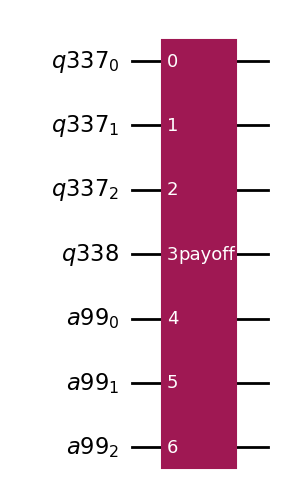

In [44]:
from qiskit.circuit.library import LinearAmplitudeFunction

def build_circuit_option_price_to_payoff_amplitude():
    circuit = LinearAmplitudeFunction(num_price_qubits, [0, 1], [0, 0],
        domain=(0, (2**num_price_qubits)-1),
        image=(0, (2**num_price_qubits)-1 - strike_price),
        breakpoints=[0, strike_price],
        rescaling_factor=c_approx,
        name='payoff')

    return circuit

test = build_circuit_option_price_to_payoff_amplitude()
test.decompose().draw('mpl')

In [45]:
from qiskit.circuit.library import OR

def build_circuit_option_price_american(num_time_steps, num_price_qubits, erdt):
    if num_time_steps < 4:
        raise ValueError('Time steps less than 4 are not supported')

    # Create the different registers needed for the circuit. Add them to the circuit in the order that they are listed in Fig. 5 of the paper
    price_registers = [QuantumRegister(num_price_qubits, 'S_'+str(t+1)) for t in range(num_time_steps)]
    tau_registers = [QuantumRegister(1, 'tau_'+str(t)) for t in range(1, num_time_steps)]
    EX_registers = [QuantumRegister(1, 'EX_'+str(t)) for t in range(2, num_time_steps)]
    value_registers = [QuantumRegister(num_price_qubits, 'V_'+str(t+1)) for t in range(num_time_steps)]
    payoff_qubit = QuantumRegister(1, 'obj')

    circuit = QuantumCircuit()

    circuit.add_register(price_registers[0])
    circuit.add_register(tau_registers[0])
    circuit.add_register(value_registers[0])
    for i in range(1, num_time_steps-1):
        circuit.add_register(price_registers[i])
        circuit.add_register(tau_registers[i])
        circuit.add_register(EX_registers[i-1])
        circuit.add_register(value_registers[i])
    
    circuit.add_register(price_registers[-1])
    circuit.add_register(value_registers[-1])
    circuit.add_register(payoff_qubit)

    price_to_payoff_circuit = build_circuit_option_price_to_payoff_register()
    or_gate = OR(2)


    # load price distributions
    price_register_range = 2**num_price_qubits - 1
    for i, register in enumerate(price_registers):
        # Load the price of the asset at each time step. Assume normally distributed
        mu = price_register_range * (erdt**i) / 2 # mean increases with risk free interest rate. Starts in the middle of our register
        sigma = (i+1) * price_register_range / num_time_steps # std linearly increases from 0, to half of the range of our price register
        distribution_circuit = build_circuit_underlying_asset_price(mu, sigma)
        circuit.append(distribution_circuit, register)
    
    circuit.barrier()
    # ---------------
    # First time step
    # Append stopping rule and requisite ancillas
    gate = stopping_rule_circuit(0)
    ancilla_register = QuantumRegister(gate.num_ancillas)
    circuit.add_register(ancilla_register)
    circuit.append(gate, qargs = [*price_registers[0], *tau_registers[0], *ancilla_register])
    # Append payoff circuit for said time step
    circuit.append(price_to_payoff_circuit.control(), qargs = [*tau_registers[0],*price_registers[0], *value_registers[0]])

    circuit.barrier()
    # ----------------
    # Second time step
    # Append stopping rule circuit and requisite ancillas
    gate = stopping_rule_circuit(1)
    ancilla_register = QuantumRegister(gate.num_ancillas)
    circuit.add_register(ancilla_register)
    circuit.append(gate, qargs = [*price_registers[1], *tau_registers[1], *ancilla_register])
    # Append 'has option been exercised' circuit
    circuit.append(or_gate, qargs = [*tau_registers[0], *tau_registers[1], *EX_registers[0]])
    
    # Calculate value of the option if it has been exercised
    circuit.append(build_circuit_payoff_to_payoff_plus_interest(erdt), qargs=[*tau_registers[0], *value_registers[0], *value_registers[1]])
    circuit.append(price_to_payoff_circuit.control(num_ctrl_qubits=2, ctrl_state='10'), qargs = [*tau_registers[0], *tau_registers[1], *price_registers[1], *value_registers[1]])
    
    circuit.barrier()
    # -----------------
    # Middle time steps
    for i in range(2, num_time_steps-1):
        # Stopping rule
        gate = stopping_rule_circuit(i)
        ancilla_register = QuantumRegister(gate.num_ancillas)
        circuit.add_register(ancilla_register)
        circuit.append(gate, qargs = [*price_registers[1], *tau_registers[1], *ancilla_register])

        # or gate if the option has been exercised yet
        circuit.append(or_gate, qargs = [*EX_registers[i-2], *tau_registers[i], *EX_registers[i-1]])

        # Calculate value of the option if it has been exercised
        circuit.append(build_circuit_payoff_to_payoff_plus_interest(erdt), qargs=[*EX_registers[i-2], *value_registers[i-1], *value_registers[i]])
        circuit.append(price_to_payoff_circuit.control(num_ctrl_qubits=2, ctrl_state='10'), qargs = [*EX_registers[i-2], *tau_registers[i], *price_registers[i], *value_registers[i]])
        circuit.barrier()
    # ---------------
    # Final time step
    circuit.append(build_circuit_payoff_to_payoff_plus_interest(erdt), qargs=[*EX_registers[-1], *value_registers[-2], *value_registers[-1]])
    circuit.append(build_circuit_option_price_to_payoff_register().control(ctrl_state='0'), qargs = [*EX_registers[-1], *price_registers[-1], *value_registers[-1]])
    
    payoff_circuit = build_circuit_option_price_to_payoff_amplitude()
    ancilla_register = QuantumRegister(payoff_circuit.num_ancillas)
    circuit.add_register(ancilla_register)
    circuit.append(payoff_circuit, qargs=[*value_registers[-1],*payoff_qubit, *ancilla_register])
    return circuit

test = build_circuit_option_price_american(num_time_steps, num_price_qubits, erdt)

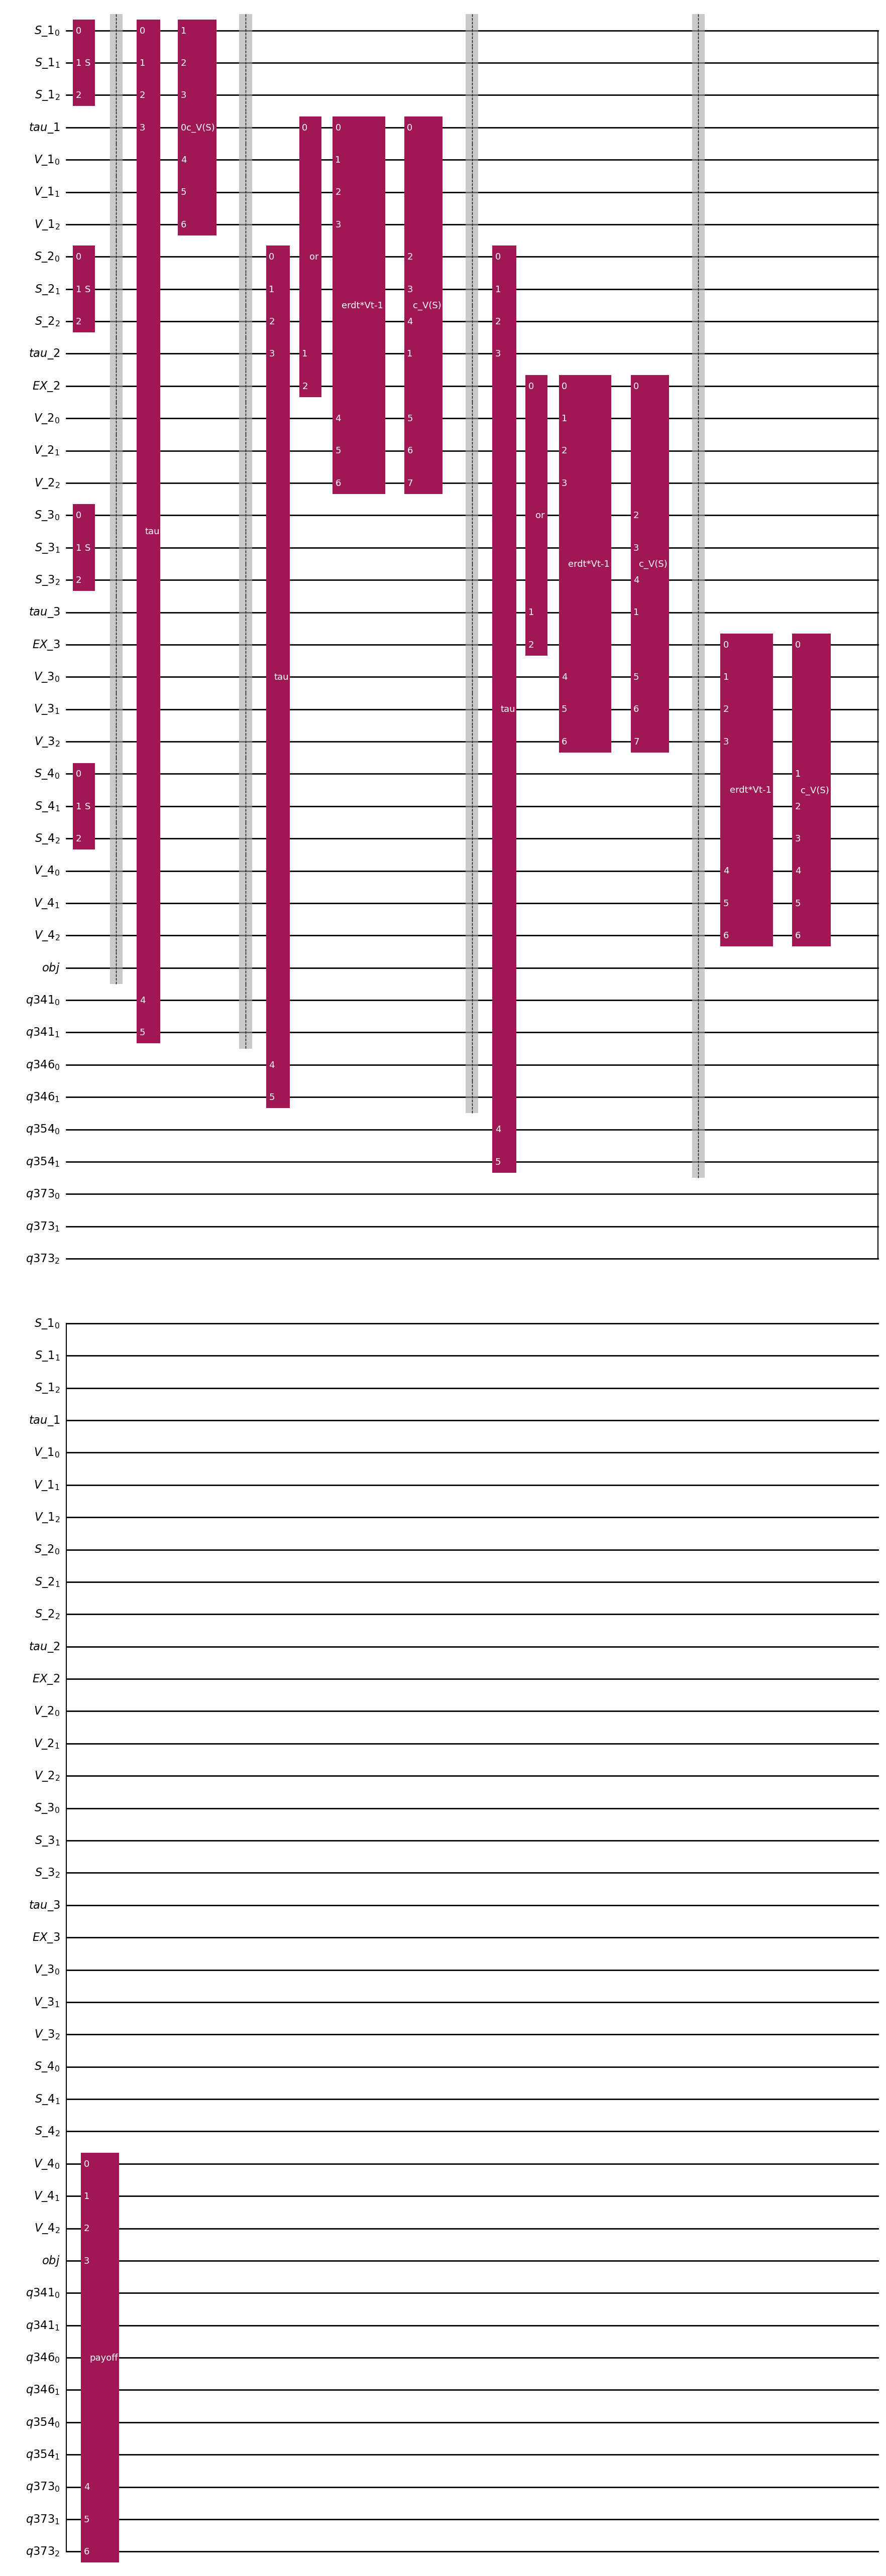

In [46]:
test.draw('mpl')